In [1]:
!pip install sentence-transformers scikit-learn matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from typing import List, Dict, Tuple, Any
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# plotting settings
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

In [4]:
def load_json(file_path: str) -> List[Dict]:
    """Load data from JSON file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        print(f"Successfully loaded {len(data)} records from {file_path}")
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON file: {e}")
        return []
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return []

In [5]:
file_path = "/content/examples_text_summary_pair.json"

data = load_json(file_path)

if data:
    print(f"Total records loaded: {len(data)}")
    print(f"Sample record keys: {list(data[0].keys())}")
    print(f"Sample record ID: {data[0]['id']}")
else:
    print("No data loaded")

Successfully loaded 122 records from /content/examples_text_summary_pair.json
Total records loaded: 122
Sample record keys: ['id', 'original', 'summary']
Sample record ID: Example 1.1


In [6]:
content_file_path = "/content/content_split.json"

content_data = load_json(content_file_path)

if content_data:
    print(f"Total records loaded: {len(content_data)}")
    print(f"Sample record keys: {list(content_data[0].keys())}")

Successfully loaded 386 records from /content/content_split.json
Total records loaded: 386
Sample record keys: ['chapter', 'text']


In [7]:
# Data exploration
if data:
    print("Data Structure Analysis:")
    print(f"Number of examples: {len(data)}")
    print(f"Keys in each record: {list(data[0].keys())}")

    # Check for missing data
    missing_summaries = sum(1 for item in data if not item.get('summary'))
    missing_originals = sum(1 for item in data if not item.get('original'))

    print(f"Records missing summaries: {missing_summaries}")
    print(f"Records missing originals: {missing_originals}")

    # Show example IDs
    example_ids = [item['id'] for item in data[:10]]
    print(f"First 10 example IDs: {example_ids}")

    # Text length statistics
    summary_lengths = [len(item['summary']) for item in data if item.get('summary')]
    original_lengths = [len(item['original']) for item in data if item.get('original')]

    print(f"Summary length stats - Mean: {np.mean(summary_lengths):.1f}, Min: {min(summary_lengths)}, Max: {max(summary_lengths)}")
    print(f"Original length stats - Mean: {np.mean(original_lengths):.1f}, Min: {min(original_lengths)}, Max: {max(original_lengths)}")

Data Structure Analysis:
Number of examples: 122
Keys in each record: ['id', 'original', 'summary']
Records missing summaries: 0
Records missing originals: 0
First 10 example IDs: ['Example 1.1', 'Example 1.2', 'Example 1.3', 'Example 2.1', 'Example 2.2', 'Example 2.3', 'Example 2.4', 'Example 2.5', 'Example 2.6', 'Example 3.1']
Summary length stats - Mean: 615.6, Min: 403, Max: 974
Original length stats - Mean: 1229.0, Min: 415, Max: 2497


In [8]:
def extract_texts_and_ids(data: List[Dict]) -> Tuple[List[str], List[str], List[str]]:
    originals = []
    summaries = []
    ids = []
    for item in data:
        originals.append(item.get('original', ''))
        summaries.append(item.get('summary', ''))
        ids.append(item.get('id', ''))
    return originals, summaries, ids

In [9]:
originals, summaries, ids = extract_texts_and_ids(data)
print(f"Extracted {len(originals)} originals, {len(summaries)} summaries, and {len(ids)} IDs.")

Extracted 122 originals, 122 summaries, and 122 IDs.


In [10]:
def extract_texts_and_chapters(data: List[Dict]) -> Tuple[List[str], List[str]]:
    texts = []
    chapters = []

    for item in data:
        texts.append(item.get('text', ''))
        chapters.append(item.get('chapter', ''))
    return texts, chapters

In [11]:
texts, chapters = extract_texts_and_chapters(content_data)
print(f"Extracted {len(texts)} texts and {len(chapters)} chapters.")

Extracted 386 texts and 386 chapters.


In [20]:
originals_embeddings = np.load("/content/original_embeddings.npy")
summaries_embeddings = np.load("/content/summaries_embeddings.npy")
content_embeddings = np.load("/content/content_embeddings.npy")

In [10]:
# Create Embeddings
def create_embeddings(texts: List[str], model_name: str = "jinaai/jina-embeddings-v3") -> np.ndarray:
    print(f"Loading embedding model: {model_name}")

    try:
        model = SentenceTransformer(model_name, trust_remote_code=True)
        model.to(device)
        print("Model loaded successfully!")

        print(f"Create embeddings for {len(texts)} texts")
        embeddings = model.encode(
            texts,
            show_progress_bar=True,
            normalize_embeddings=True,
            device=device,
        )

        print(f"Embeddings created with shape: {embeddings.shape}")
        print(f"Embeding dimension: {embeddings.shape[1]}")

        return embeddings
    except Exception as e:
        print(f"Error creating embeddings: {e}")
        return np.array([])

In [11]:
if originals:
    originals_embeddings = create_embeddings(originals)

    if originals_embeddings is not None and originals_embeddings.size > 0:
        print("Originals embeddings created successfully!")

        # Embeddings Info.
        print(f"Mean embedding (scalar): {np.mean(originals_embeddings):.4f}")
        print(f"Std embedding (scalar): {np.std(originals_embeddings):.4f}")
        print(f"Min embedding (scalar): {np.min(originals_embeddings):.4f}")
        print(f"Max embedding (scalar): {np.max(originals_embeddings):.4f}")
    else:
        print("Failed to create originals embeddings.")

Loading embedding model: jinaai/jina-embeddings-v3


modules.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/734k [00:00<?, ?B/s]

custom_st.py:   0%|          | 0.00/8.78k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v3:
- custom_st.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
- mha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- embedding.py
- xlm_padding.py
- mlp.py
- rotary.py
- block.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downl

model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

Model loaded successfully!
Create embeddings for 122 texts


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Embeddings created with shape: (122, 1024)
Embeding dimension: 1024
Originals embeddings created successfully!
Mean embedding (scalar): 0.0001
Std embedding (scalar): 0.0313
Min embedding (scalar): -0.2480
Max embedding (scalar): 0.2412


In [12]:
if summaries:
    summaries_embeddings = create_embeddings(summaries)

    if summaries_embeddings is not None and summaries_embeddings.size > 0:
        print("Originals embeddings created successfully!")

        # Embeddings Info.
        print(f"Mean embedding (scalar): {np.mean(originals_embeddings):.4f}")
        print(f"Std embedding (scalar): {np.std(originals_embeddings):.4f}")
        print(f"Min embedding (scalar): {np.min(originals_embeddings):.4f}")
        print(f"Max embedding (scalar): {np.max(originals_embeddings):.4f}")
    else:
        print("Failed to create summaries embeddings")

Loading embedding model: jinaai/jina-embeddings-v3


Model loaded successfully!
Create embeddings for 122 texts


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Embeddings created with shape: (122, 1024)
Embeding dimension: 1024
Originals embeddings created successfully!
Mean embedding (scalar): 0.0001
Std embedding (scalar): 0.0313
Min embedding (scalar): -0.2480
Max embedding (scalar): 0.2412


In [46]:
if texts:
    content_embeddings = create_embeddings(texts)

    if content_embeddings is not None and content_embeddings.size > 0:
        print("Content embeddings created successfully!")

        # Embeddings Info.
        print(f"Mean embedding (scalar): {np.mean(content_embeddings):.4f}")
        print(f"Std embedding (scalar): {np.std(content_embeddings):.4f}")
    else:
        print("Failed to create content embeddings.")

Loading embedding model: jinaai/jina-embeddings-v3


Model loaded successfully!
Create embeddings for 386 texts


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Error creating embeddings: CUDA out of memory. Tried to allocate 29.29 GiB. GPU 0 has a total capacity of 14.74 GiB of which 10.04 GiB is free. Process 8557 has 4.70 GiB memory in use. Of the allocated memory 4.52 GiB is allocated by PyTorch, and 59.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Failed to create content embeddings.


In [13]:
# util function for visualization
# extract question chapter id
import re

def extract_class_ids(ids: List[str]) -> List[int]:
    class_ids = []
    for id_str in ids:
        match = re.match(r"Example (\d+)\.\d+", id_str) # chapter num. extraction
        if match:
            class_ids.append(int(match.group(1)))
        else:
            class_ids.append(-1)  # fallback
    return class_ids

In [21]:
# util function for visualization
# point color by chapter class
import matplotlib.cm as cm

def get_colors_by_class_ids(class_ids: List[int], cmap_name="tab20") -> List:
    unique_classes = sorted(set(class_ids))
    n_classes = len(unique_classes)
    cmap = cm.get_cmap(cmap_name, n_classes)
    color_map = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
    return [color_map[cls] for cls in class_ids]

In [22]:
def extract_chapter_ids(chapters: List[int]) -> List[int]:
    """
    챕터 리스트를 정수 ID로 반환 (이미 정수면 그대로 반환)
    """
    return [int(ch) if isinstance(ch, int) else -1 for ch in chapters]

In [23]:
def get_colors_by_chapter_ids(chapter_ids: List[int], cmap_name="tab20") -> List:
    """
    각 chapter ID에 고유한 색상을 할당
    """
    unique_chapters = sorted(set(chapter_ids))
    n_chapters = len(unique_chapters)
    cmap = cm.get_cmap(cmap_name, n_chapters)
    color_map = {ch: cmap(i) for i, ch in enumerate(unique_chapters)}
    return [color_map[ch] for ch in chapter_ids]

In [24]:
# PCA

def visualize_embeddings_pca(embeddings: np.ndarray, labels: List[str], n_components: int=2, figsize: Tuple[int, int] = (12, 8)):
    pca = PCA(n_components=n_components, random_state=42)
    embeddings_2d = pca.fit_transform(embeddings)

    explained_variance_ratio = pca.explained_variance_ratio_  # 각 주성분(축)이 전체 데이터의 변동성(정보)를 얼마나 잘 설명하는지 (높을수록 good, 낮은 차원으로 줄여도 더 많은 정보 담을 수 있다는 의미)
    print(f"Explained variance ratio for {n_components} components: {explained_variance_ratio}") # [0,1]
    print(f"Total explained variance ratio: {sum(explained_variance_ratio)}") # 1에 가까울수록 원래 데이터 정보 그대로 보존

    class_ids = extract_class_ids(ids)
    colors = get_colors_by_class_ids(class_ids)

    # Create figure
    plt.figure(figsize=figsize)
    scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:, 1], c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    # alpha: 점의 투명도, s: 점의 크기

    # label for each point
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings_2d[i,0], embeddings_2d[i,1]), xytext=(5,5), textcoords='offset points', fontsize=8, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        # 라벨을 점과 동일한 위치 (embeddings_2d[i,0], embeddings_2d[i,1])에 적되,
        # xytext=(5,5): 약간 오른쪽 위로 밀어서 글자가 겹치지 않게
    plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2%} variance explained)', fontsize=12)
    plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2%} variance explained)', fontsize=12)

    plt.title('Text Embeddings Visualization using PCA', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()

    return embeddings_2d, pca

In [46]:
def plot_content_embeddings_pca(pca_embeddings: np.ndarray, chapters: List[str], title: str, n_components: int=2, figsize: Tuple[int, int] = (12, 8)):

    chapter_ids = extract_chapter_ids(chapters)
    colors = get_colors_by_chapter_ids(chapter_ids)

    # Create figure
    plt.figure(figsize=figsize)
    scatter = plt.scatter(pca_embeddings[:,0], pca_embeddings[:, 1], c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    # alpha: 점의 투명도, s: 점의 크기

    # label for each point
    for i, label in enumerate(chapters):
        plt.annotate(label, (pca_embeddings[i,0], pca_embeddings[i,1]), xytext=(5,5), textcoords='offset points', fontsize=8, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    plt.xlabel(f'Principal Component 1', fontsize=12)
    plt.ylabel(f'Principal Component 2', fontsize=12)

    plt.title('Text Embeddings Visualization using PCA', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()

In [53]:
# Noise reduction by scaling

from sklearn.preprocessing import StandardScaler

def visualize_embeddings_pca_scaled(embeddings: np.ndarray, labels: List[str], title: str, n_components: int=2, figsize: Tuple[int, int] = (12, 8)):
    X_scaled = StandardScaler().fit_transform(embeddings)

    pca = PCA(n_components=n_components, random_state=0)
    pca = pca.fit(X_scaled)
    embeddings_2d = pca.fit_transform(embeddings)

    explained_variance_ratio = pca.explained_variance_ratio_  # 각 주성분(축)이 전체 데이터의 변동성(정보)를 얼마나 잘 설명하는지 (높을수록 good, 낮은 차원으로 줄여도 더 많은 정보 담을 수 있다는 의미)
    print(f"Explained variance ratio for {n_components} components: {explained_variance_ratio}") # [0,1]
    print(f"Total explained variance ratio: {sum(explained_variance_ratio)}") # 1에 가까울수록 원래 데이터 정보 그대로 보존

    class_ids = extract_class_ids(ids)
    colors = get_colors_by_class_ids(class_ids)

    # Create figure
    plt.figure(figsize=figsize)
    scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:, 1], c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    # alpha: 점의 투명도, s: 점의 크기

    # label for each point
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings_2d[i,0], embeddings_2d[i,1]), xytext=(5,5), textcoords='offset points', fontsize=8, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        # 라벨을 점과 동일한 위치 (embeddings_2d[i,0], embeddings_2d[i,1])에 적되,
        # xytext=(5,5): 약간 오른쪽 위로 밀어서 글자가 겹치지 않게
    plt.xlabel(f'Principal Component 1', fontsize=12)
    plt.ylabel(f'Principal Component 2', fontsize=12)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()

    return embeddings_2d, pca

Explained variance ratio for 2 components: [0.10118138 0.06797666]
Total explained variance ratio: 0.16915804147720337


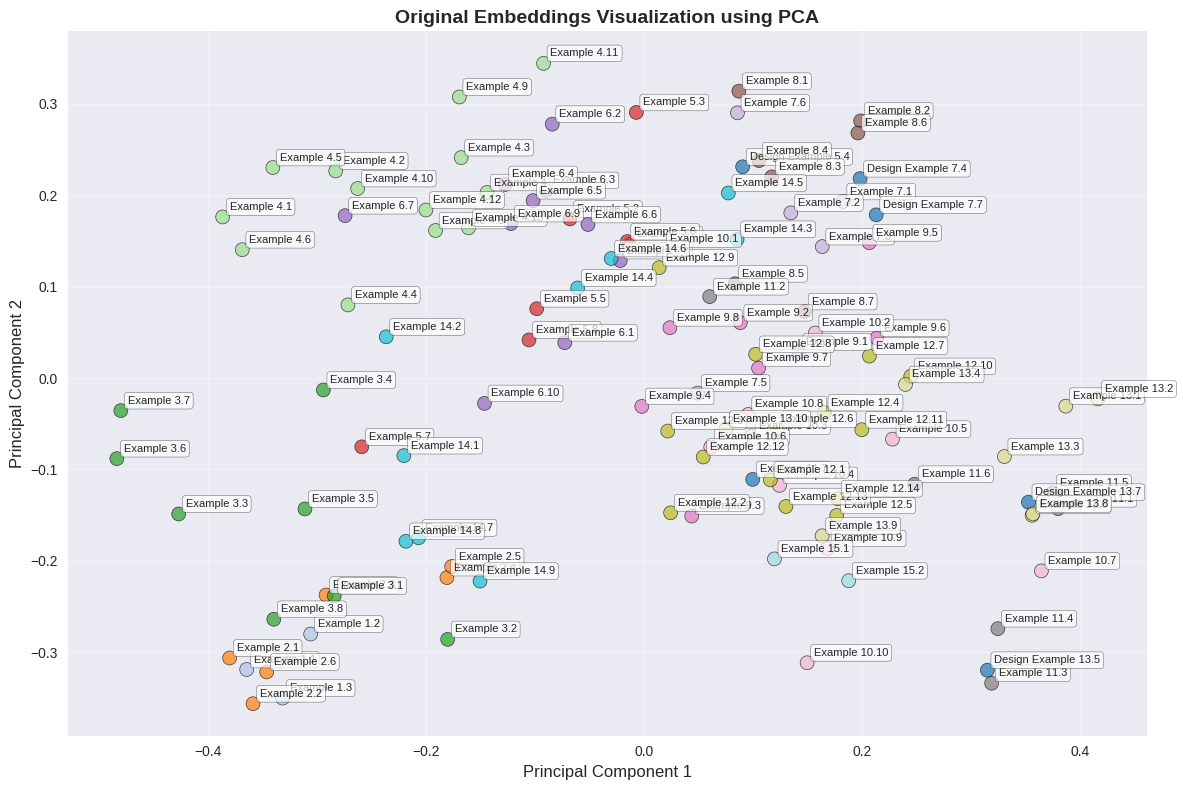

In [54]:
if originals_embeddings is not None and ids:
    originals_pca_embeddings, originals_pca_model = visualize_embeddings_pca_scaled(originals_embeddings, ids, "Original Embeddings Visualization using PCA")
else:
    print("Embeddings or labels not available for PCA visualization.")

Explained variance ratio for 2 components: [0.10250039 0.07035045]
Total explained variance ratio: 0.1728508472442627


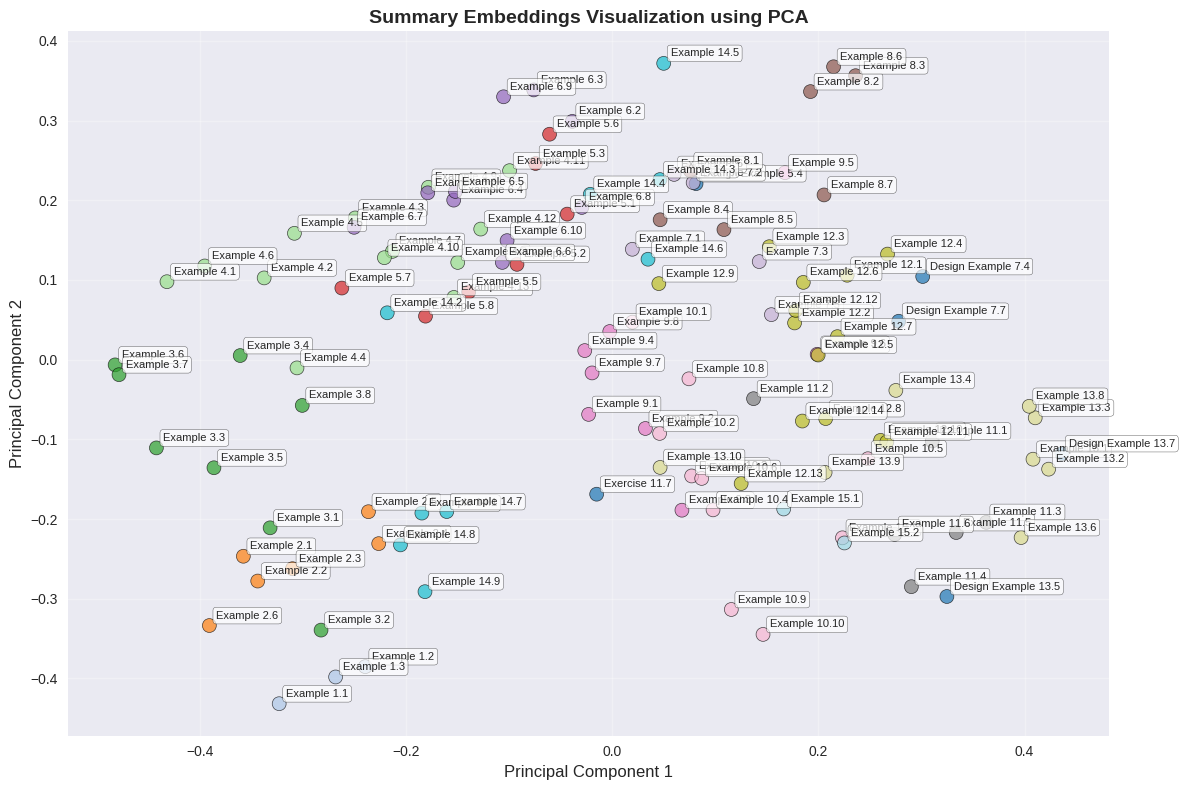

In [55]:
if summaries_embeddings is not None and ids:
    summaries_pca_embeddings, summaries_pca_model = visualize_embeddings_pca_scaled(summaries_embeddings, ids, "Summary Embeddings Visualization using PCA")
else:
    print("Embeddings or labels not available for PCA visualization.")

In [56]:
def plot_content_embeddings_pca_scaled(embeddings: np.ndarray, chapters: List[str], title: str, n_components: int=2, figsize: Tuple[int, int] = (12, 8)):
    X_scaled = StandardScaler().fit_transform(embeddings)

    pca = PCA(n_components=n_components, random_state=0)
    pca = pca.fit(X_scaled)
    embeddings_2d = pca.fit_transform(embeddings)

    chapter_ids = extract_chapter_ids(chapters)
    colors = get_colors_by_chapter_ids(chapter_ids)

    # Create figure
    plt.figure(figsize=figsize)
    scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:, 1], c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    # alpha: 점의 투명도, s: 점의 크기

    # label for each point
    for i, label in enumerate(chapters):
        plt.annotate(label, (embeddings_2d[i,0], embeddings_2d[i,1]), xytext=(5,5), textcoords='offset points', fontsize=8, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    plt.xlabel(f'Principal Component 1', fontsize=12)
    plt.ylabel(f'Principal Component 2', fontsize=12)

    plt.title('Text Embeddings Visualization using PCA', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return embeddings_2d, pca

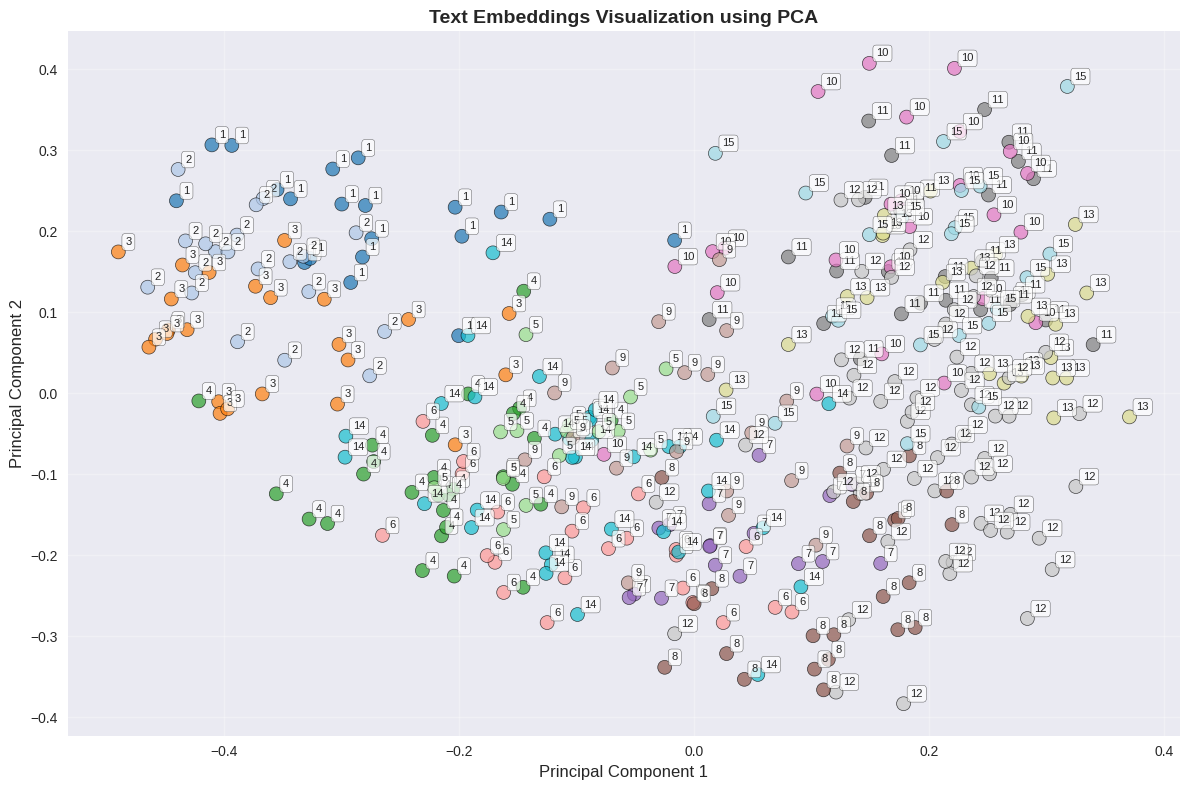

In [59]:
if content_embeddings is not None and ids:
    content_pca_embeddings, content_pca_model = plot_content_embeddings_pca_scaled(content_embeddings, chapters, "Content Embeddings Visualization using PCA")
else:
    print("Embeddings or labels not available for PCA visualization.")

## t-SNE

In [71]:
def visualize_embeddings_tsne_20(embeddings: np.ndarray, labels: List[str], title: str, perplexity: int=20, n_iter: int=1000, figsize: Tuple[int, int]=(12,8)):
    print(f"Applying t-SNE with perplexity={perplexity}, n_iter={n_iter}")

    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42, verbose=1)
    embeddings_2d = tsne.fit_transform(embeddings)

    print("Succesfully completed t-SNE!")
    print(f"Final KL divergence: {tsne.kl_divergence_:.4f}")

    class_ids = extract_class_ids(ids)
    colors = get_colors_by_class_ids(class_ids)

    # Create figure
    plt.figure(figsize=figsize)
    scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:, 1], c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings_2d[i,0], embeddings_2d[i,1]), xytext=(5,5), textcoords='offset points', fontsize=8, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()

    return embeddings_2d, tsne

Applying t-SNE with perplexity=20, n_iter=1000
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 122 samples in 0.001s...
[t-SNE] Computed neighbors for 122 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 122 / 122
[t-SNE] Mean sigma: 0.320266
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.227287
[t-SNE] KL divergence after 1000 iterations: 0.466411
Succesfully completed t-SNE!
Final KL divergence: 0.4664


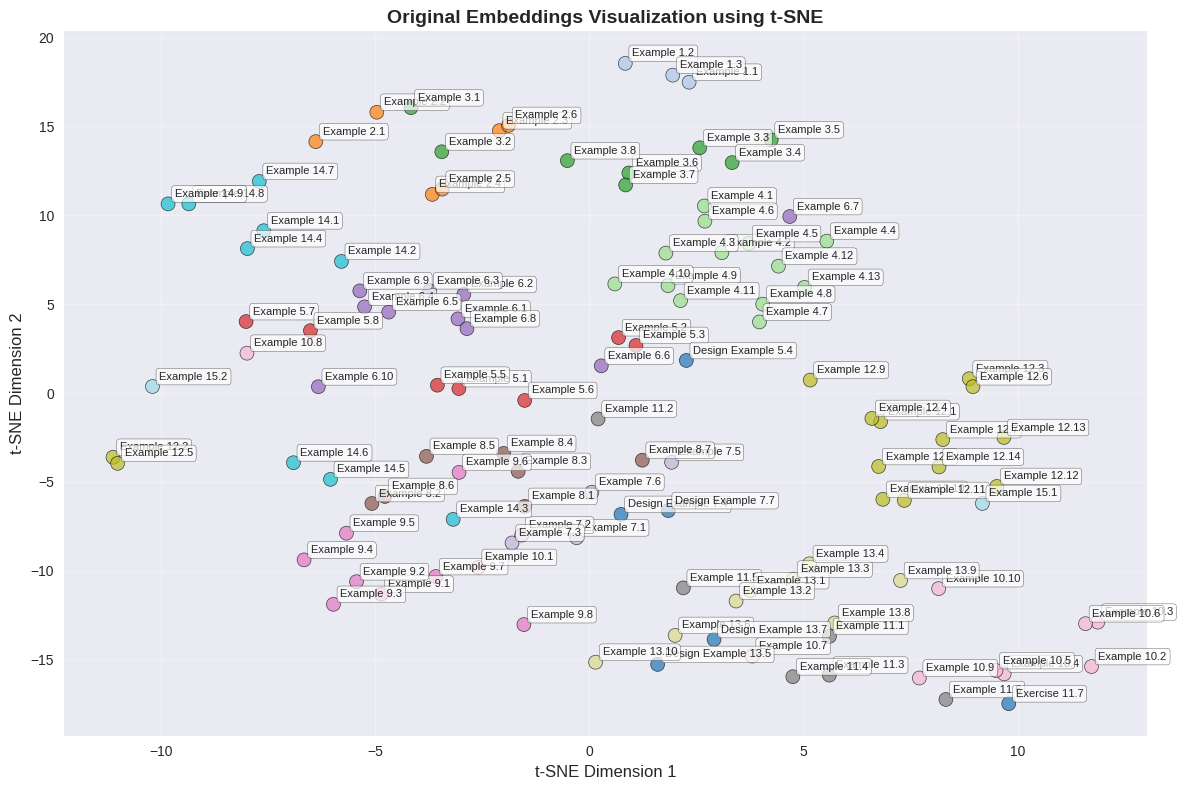

In [72]:
if originals_embeddings is not None and ids:
    originals_tsne_20_embeddings, originals_tsne_20_model = visualize_embeddings_tsne_20(originals_embeddings, ids, "Original Embeddings Visualization using t-SNE")
else:
    print("Embeddings or labels not available for t-SNE visualization.")

Applying t-SNE with perplexity=20, n_iter=1000
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 122 samples in 0.003s...
[t-SNE] Computed neighbors for 122 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 122 / 122
[t-SNE] Mean sigma: 0.330148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.010952
[t-SNE] KL divergence after 1000 iterations: 0.536888
Succesfully completed t-SNE!
Final KL divergence: 0.5369


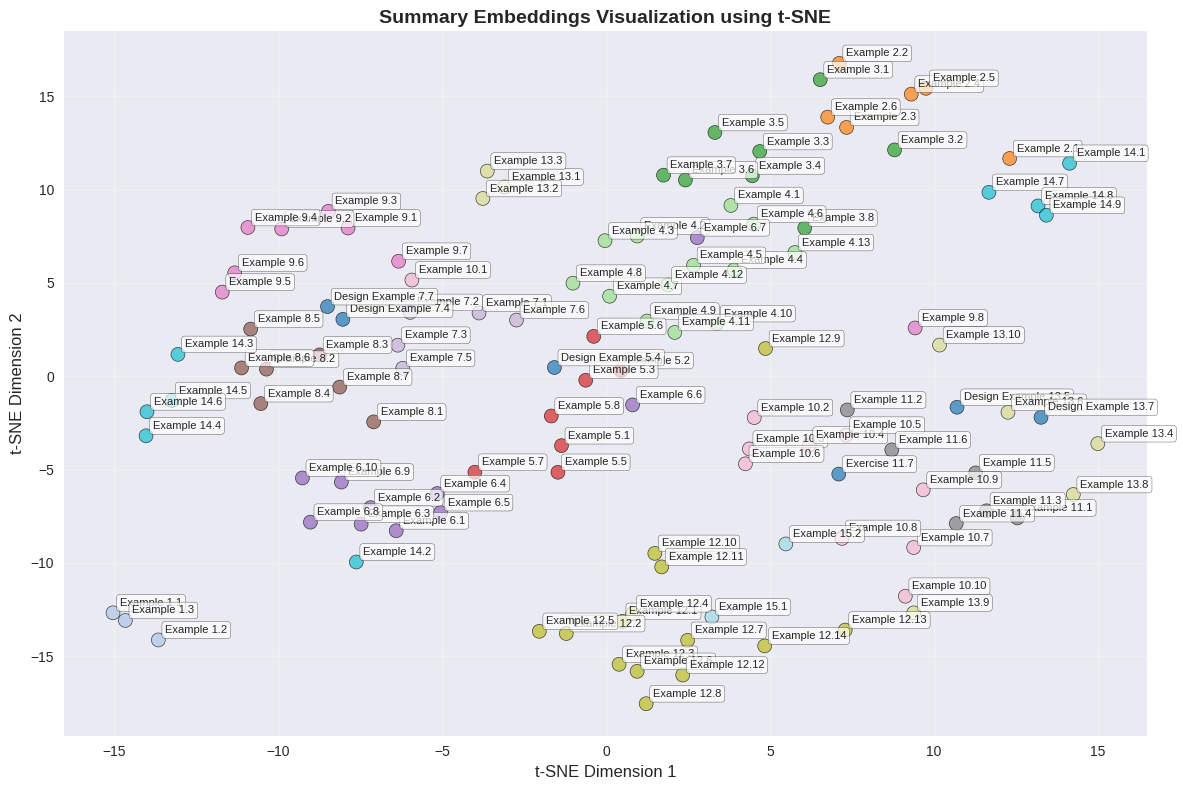

In [70]:
if summaries_embeddings is not None and ids:
    summaries_tsne_20_embeddings, summaries_tsne_20_model = visualize_embeddings_tsne_20(summaries_embeddings, ids, "Summary Embeddings Visualization using t-SNE")
else:
    print("Embeddings or labels not available for t-SNE visualization.")

In [95]:
def _extract_numeric_suffix(label: str) -> str:
    """
    "Example 3.7"  ->  "3.7"
    "Design Example 12.3" -> "12.3"
    """
    m = re.search(r'(\d+\.\d+)$', label.strip())
    return m.group(1) if m else label

In [100]:
def visualize_combined_pca(original_emb: np.ndarray, summary_emb: np.ndarray, labels: List[str], figsize: Tuple[int, int]=(12,8)):
    combined_emb = np.vstack([original_emb, summary_emb])
    pca = PCA(n_components=2, random_state=0)
    combined_2d = pca.fit_transform(combined_emb)

    n_orig = original_emb.shape[0]
    orig_2d, summ_2d = combined_2d[:n_orig], combined_2d[n_orig:]

    class_ids = extract_class_ids(ids)                 # length = N
    colors    = get_colors_by_class_ids(class_ids)

    colors_orig = colors
    colors_sum = colors

    plt.figure(figsize=figsize)
    plt.scatter(orig_2d[:, 0], orig_2d[:, 1],
                c=colors_orig, marker="o", label="Original", alpha=0.7)
    plt.scatter(summ_2d[:, 0], summ_2d[:, 1],
                c=colors_sum, marker="s", label="Summary", alpha=0.7)

    for i, txt in enumerate(labels):
        num_txt = _extract_numeric_suffix(txt)

        plt.annotate(num_txt,
                     (orig_2d[i, 0], orig_2d[i, 1]),
                     xytext=(3, 3), textcoords="offset points",
                     fontsize=8,
                     bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='lightgrey', alpha=0.7))

        # Summary label  ▶ 흰색 bbox (시각적 구분)
        plt.annotate(num_txt,
                     (summ_2d[i, 0], summ_2d[i, 1]),
                     xytext=(3, 3), textcoords="offset points",
                     fontsize=8,
                     bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='white', alpha=0.7))

    plt.title("PCA – Original vs Summary", fontsize=14)
    plt.xlabel("Principal Componant 1"); plt.ylabel("Principal Component 2")
    plt.legend(); plt.grid(True); plt.show()

    return orig_2d, summ_2d, pca

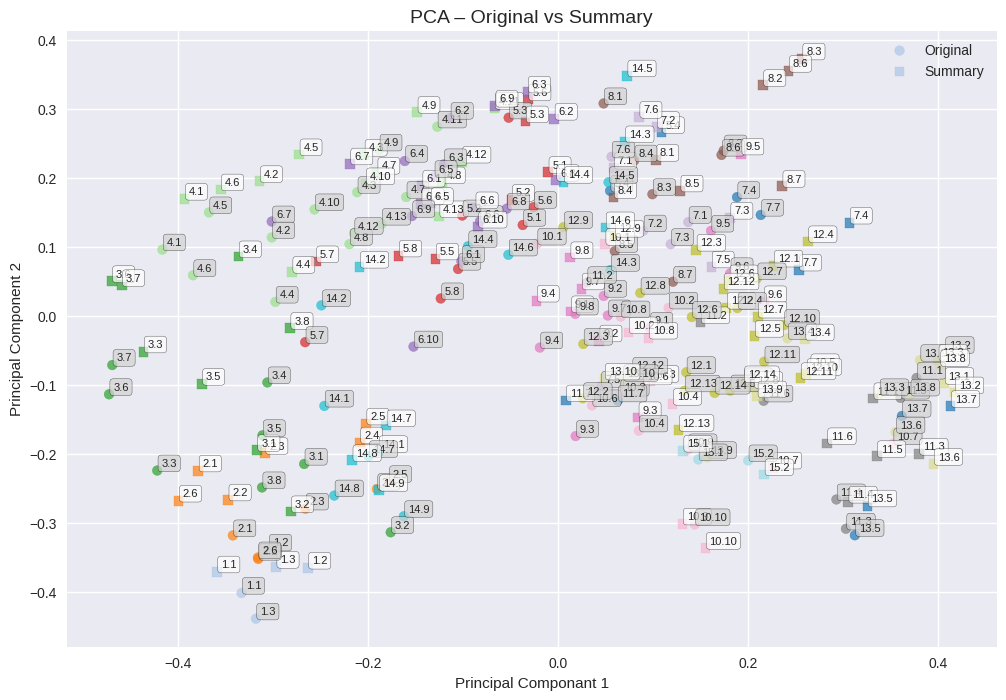

In [101]:
orig_pca_2d, summ_pca_2d, combined_pca_model = visualize_combined_pca(
    originals_embeddings, summaries_embeddings, ids
)

In [ ]:
def visualize_combined_pca(original_emb: np.ndarray, summary_emb: np.ndarray, labels: List[str], figsize: Tuple[int, int]=(12,8)):
    combined_emb = np.vstack([original_emb, summary_emb])
    pca = PCA(n_components=2, random_state=0)
    combined_2d = pca.fit_transform(combined_emb)

    n_orig = original_emb.shape[0]
    orig_2d, summ_2d = combined_2d[:n_orig], combined_2d[n_orig:]

    class_ids = extract_class_ids(ids)                 # length = N
    colors    = get_colors_by_class_ids(class_ids)

    colors_orig = colors
    colors_sum = colors

    plt.figure(figsize=figsize)
    plt.scatter(orig_2d[:, 0], orig_2d[:, 1],
                c=colors_orig, marker="o", label="Original", alpha=0.7)
    plt.scatter(summ_2d[:, 0], summ_2d[:, 1],
                c=colors_sum, marker="s", label="Summary", alpha=0.7)

    for i, txt in enumerate(labels):
        num_txt = _extract_numeric_suffix(txt)

        plt.annotate(num_txt,
                     (orig_2d[i, 0], orig_2d[i, 1]),
                     xytext=(3, 3), textcoords="offset points",
                     fontsize=8,
                     bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='lightgrey', alpha=0.7))

        # Summary label  ▶ 흰색 bbox (시각적 구분)
        plt.annotate(num_txt,
                     (summ_2d[i, 0], summ_2d[i, 1]),
                     xytext=(3, 3), textcoords="offset points",
                     fontsize=8,
                     bbox=dict(boxstyle='round,pad=0.3',
                               facecolor='white', alpha=0.7))

    plt.title("PCA – Original vs Summary", fontsize=14)
    plt.xlabel("Principal Componant 1"); plt.ylabel("Principal Component 2")
    plt.legend(); plt.grid(True); plt.show()

    return orig_2d, summ_2d, pca

In [92]:
def compare_projections(
    orig_pca: np.ndarray,
    orig_question_pca: np.ndarray,
    summ_pca: np.ndarray,
    summ_question_pca: np.ndarray
):
    """
    PCA와 t-SNE 공간에서 '원문 ↔ 요약' 쌍의 관계를
    거리·분산·상관계수 등으로 정량 비교하여 깔끔하게 출력한다.
    """
    # 각 포인트 쌍(원문, 요약) 간 유클리드 거리
    pca_org_dists  = np.linalg.norm(orig_pca  - orig_question_pca,  axis=1)
    pca_summ_dists = np.linalg.norm(summ_pca - summ_question_pca, axis=1)

    # 핵심 통계량 계산
    stats = {
        "Metric": [
            "PCA   – 평균 거리", "PCA   – 중앙값", "PCA   – 표준편차",
            "t-SNE – 평균 거리", "t-SNE – 중앙값", "t-SNE – 표준편차",
            "PCA vs t-SNE – 거리 상관계수",
            "PCA   – 원문 분산 합", "PCA   – 요약 분산 합",
            "t-SNE – 원문 분산 합", "t-SNE – 요약 분산 합"
        ],
        "Value": [
            pca_org_dists.mean(),   np.median(pca_org_dists),  pca_org_dists.std(),
            pca_summ_dists.mean(),  np.median(pca_summ_dists), pca_summ_dists.std(),
            np.corrcoef(pca_org_dists, pca_summ_dists)[0, 1],
            np.var(orig_pca,  axis=0).sum(), np.var(orig_question_pca, axis=0).sum(),
            np.var(summ_pca, axis=0).sum(), np.var(summ_question_pca, axis=0).sum()
        ]
    }

    df = pd.DataFrame(stats)
    print("\n===  Orig vs Summary Embedding Comparison  ===")
    print(df.to_string(index=False, formatters={"Value": "{:,.4f}".format}))

SyntaxError: invalid syntax (<ipython-input-92-1938030437>, line 13)

In [ ]:
compare_projections(orig_pca_2d, summ_pca_2d, orig_tsne_2d, summ_tsne_2d)

In [86]:
# Save Results
import os

output_dir = "/content/embeddings_results_final"
os.makedirs(output_dir, exist_ok=True)

# Save embeddings
np.save(os.path.join(output_dir, 'originals_embeddings.npy'), originals_embeddings)
np.save(os.path.join(output_dir, 'summaries_embeddings.npy'), summaries_embeddings)
np.save(os.path.join(output_dir, 'originals_pca_embeddings.npy'), originals_pca_embeddings)
np.save(os.path.join(output_dir, 'summaries_pca_embeddings.npy'), summaries_pca_embeddings)
np.save(os.path.join(output_dir, 'originals_tsne_embeddings.npy'), originals_tsne_20_embeddings)
np.save(os.path.join(output_dir, 'summaries_tsne_embeddings.npy'), summaries_tsne_20_embeddings)


with open(os.path.join(output_dir, 'labels.txt'), 'w') as f:
    for label in ids:
        f.write(f"{label}\n")

# Create summary dataframe
results_df = pd.DataFrame({
    'id': ids,
    'originals_pca_x': originals_pca_embeddings[:,0],
    'originals_pca_y': originals_pca_embeddings[:,1],
    'summaries_pca_x': summaries_pca_embeddings[:,0],
    'summaries_pca_y': summaries_pca_embeddings[:,1],
    'originals_tsne_x': originals_tsne_20_embeddings[:,0],
    'originals_tsne_y': originals_tsne_20_embeddings[:,1],
    'summaries_tsne_x': summaries_tsne_20_embeddings[:,0],
    'summaries_tsne_y': summaries_tsne_20_embeddings[:,1]
})

results_df.to_csv(os.path.join(output_dir, 'visualization_coordinates.csv'), index=False)

print(f"Successfully saved results to {output_dir}")

Successfully saved results to /content/embeddings_results_final


In [87]:
# -- Metric Calculation for Embedding Cluster Quality --

from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

originals_chapter_labels = extract_class_ids(ids)
summaries_chapter_labels = extract_class_ids(ids)

def intra_inter_distances(X, labels):
    """Calculate mean intra-cluster and inter-cluster (centroid) distances."""
    unique = np.unique(labels)
    centroids = np.vstack([X[labels == u].mean(0) for u in unique])
    # intra: 평균적으로 각 점이 자기 소속 centroid와 얼마나 가까운지
    intra = np.mean([cdist(X[labels == u], [centroids[i]]).mean() for i, u in enumerate(unique)])
    # inter: 서로 다른 centroid 간 거리 평균
    inter = cdist(centroids, centroids)
    inter[range(len(unique)), range(len(unique))] = np.nan  # diagonal 제외
    mean_inter = np.nanmean(inter)
    return intra, mean_inter

# -- Original Embeddings --
orig_sil = silhouette_score(originals_embeddings, originals_chapter_labels)
orig_db = davies_bouldin_score(originals_embeddings, originals_chapter_labels)
orig_intra, orig_inter = intra_inter_distances(originals_embeddings, originals_chapter_labels)

# -- Summary Embeddings --
sum_sil = silhouette_score(summaries_embeddings, summaries_chapter_labels)
sum_db = davies_bouldin_score(summaries_embeddings, summaries_chapter_labels)
sum_intra, sum_inter = intra_inter_distances(summaries_embeddings, summaries_chapter_labels)

# -- DataFrame for Summary Table --
result_df = pd.DataFrame({
    'Metric': [
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Intra-class Distance',
        'Inter-class Distance'
    ],
    'Original': [
        orig_sil,
        orig_db,
        orig_intra,
        orig_inter
    ],
    'Summary': [
        sum_sil,
        sum_db,
        sum_intra,
        sum_inter
    ]
})

print(result_df)


                 Metric  Original   Summary
0      Silhouette Score  0.052160  0.052221
1  Davies-Bouldin Index  2.399323  2.275608
2  Intra-class Distance  0.534372  0.557558
3  Inter-class Distance  0.644979  0.682977


In [88]:
# -- Metric Calculation for Embedding Cluster Quality --

from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

originals_chapter_labels = extract_class_ids(ids)
summaries_chapter_labels = extract_class_ids(ids)

def intra_inter_distances(X, labels):
    """Calculate mean intra-cluster and inter-cluster (centroid) distances."""
    unique = np.unique(labels)
    centroids = np.vstack([X[labels == u].mean(0) for u in unique])
    # intra: 평균적으로 각 점이 자기 소속 centroid와 얼마나 가까운지
    intra = np.mean([cdist(X[labels == u], [centroids[i]]).mean() for i, u in enumerate(unique)])
    # inter: 서로 다른 centroid 간 거리 평균
    inter = cdist(centroids, centroids)
    inter[range(len(unique)), range(len(unique))] = np.nan  # diagonal 제외
    mean_inter = np.nanmean(inter)
    return intra, mean_inter

# -- Original Embeddings --
orig_sil = silhouette_score(originals_pca_embeddings, originals_chapter_labels)
orig_db = davies_bouldin_score(originals_pca_embeddings, originals_chapter_labels)
orig_intra, orig_inter = intra_inter_distances(originals_pca_embeddings, originals_chapter_labels)

# -- Summary Embeddings --
sum_sil = silhouette_score(summaries_pca_embeddings, summaries_chapter_labels)
sum_db = davies_bouldin_score(summaries_pca_embeddings, summaries_chapter_labels)
sum_intra, sum_inter = intra_inter_distances(summaries_pca_embeddings, summaries_chapter_labels)

# -- DataFrame for Summary Table --
result_df = pd.DataFrame({
    'Metric': [
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Intra-class Distance',
        'Inter-class Distance'
    ],
    'Original': [
        orig_sil,
        orig_db,
        orig_intra,
        orig_inter
    ],
    'Summary': [
        sum_sil,
        sum_db,
        sum_intra,
        sum_inter
    ]
})

print(result_df)


                 Metric  Original   Summary
0      Silhouette Score -0.132423 -0.078236
1  Davies-Bouldin Index  3.239095  2.353276
2  Intra-class Distance  0.110938  0.110036
3  Inter-class Distance  0.348799  0.377553


In [89]:
# -- Metric Calculation for Embedding Cluster Quality --

from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

originals_chapter_labels = extract_class_ids(ids)
summaries_chapter_labels = extract_class_ids(ids)

def intra_inter_distances(X, labels):
    """Calculate mean intra-cluster and inter-cluster (centroid) distances."""
    unique = np.unique(labels)
    centroids = np.vstack([X[labels == u].mean(0) for u in unique])
    # intra: 평균적으로 각 점이 자기 소속 centroid와 얼마나 가까운지
    intra = np.mean([cdist(X[labels == u], [centroids[i]]).mean() for i, u in enumerate(unique)])
    # inter: 서로 다른 centroid 간 거리 평균
    inter = cdist(centroids, centroids)
    inter[range(len(unique)), range(len(unique))] = np.nan  # diagonal 제외
    mean_inter = np.nanmean(inter)
    return intra, mean_inter

# -- Original Embeddings --
orig_sil = silhouette_score(originals_tsne_embeddings, originals_chapter_labels)
orig_db = davies_bouldin_score(originals_tsne_embeddings, originals_chapter_labels)
orig_intra, orig_inter = intra_inter_distances(originals_tsne_embeddings, originals_chapter_labels)

# -- Summary Embeddings --
sum_sil = silhouette_score(summaries_tsne_embeddings, summaries_chapter_labels)
sum_db = davies_bouldin_score(summaries_tsne_embeddings, summaries_chapter_labels)
sum_intra, sum_inter = intra_inter_distances(summaries_tsne_embeddings, summaries_chapter_labels)

# -- DataFrame for Summary Table --
result_df = pd.DataFrame({
    'Metric': [
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Intra-class Distance',
        'Inter-class Distance'
    ],
    'Original': [
        orig_sil,
        orig_db,
        orig_intra,
        orig_inter
    ],
    'Summary': [
        sum_sil,
        sum_db,
        sum_intra,
        sum_inter
    ]
})

print(result_df)


                 Metric   Original    Summary
0      Silhouette Score   0.079368   0.065834
1  Davies-Bouldin Index   2.285053   2.898529
2  Intra-class Distance   8.123378   7.955669
3  Inter-class Distance  31.032925  29.371747
